# Project 3 — Dirichlet–Neumann Domain Decomposition
This notebook demonstrates the implementation and results of a parallel Dirichlet–Neumann (D–N) iteration
for the steady-state heat equation inside a multi-room apartment.

**Tasks covered**
| PDF task | Description |
|-----------|--------------|
| Task 1 | Build discrete Laplace matrices (Δx = 1/3) |
| Task 2 | Test if the heating system is sufficient (Δx = 1/20, K = 10, ω = 0.8) |
| Task 3 | Visualize temperature distribution |
| Task 4 | Sensitivity to parameters (ω, K, heater temp) |
| Project 3a | Extended 2.5-room apartment (5 MPI processes) |


## Environment setup

In [ ]:
import os, sys, subprocess, numpy as np, matplotlib.pyplot as plt

# ---- Project path & mpiexec (Mac / Homebrew) ----
PROJECT_ROOT = ""
sys.path.append(PROJECT_ROOT)

# Find your mpiexec path
# mpiexec = r"C:\Program Files\Microsoft MPI\Bin\mpiexec.exe"

mpiexec = r"/opt/homebrew/bin/mpiexec"

assert os.path.exists(mpiexec), "Please verify your mpiexec path!"

# Output directories
os.makedirs("output", exist_ok=True)
os.makedirs("ext_output", exist_ok=True)

## Task 1 — Matrix structure demonstration (Δx = 1/3)
* Each subdomain (room) is discretized with an interior grid of size (Nx-2) × (Ny-2).
* Dirichlet boundaries remove the boundary nodes from the unknown vector and move their contribution to **b**.
* Neumann boundaries appear as ± 1/Δx terms inside **A** and **b**.
* In the D–N iteration, Ω₂ uses Dirichlet data from interfaces Γ₁, Γ₂ while Ω₁ and Ω₃ use Neumann fluxes.

In [6]:
from common.boundary_config import get_boundary_conditions
from common.utils import get_room_grid_info, get_interface_grid_info
from core.matrix_builder import build_laplace_matrix_mixed, build_b_mixed
import numpy as np

dx = dy = 1/3

iface_info = get_interface_grid_info(dx, dy)
Ny_interface = iface_info['Ny_interface'][0]   # Vertical interface matching room1/room3 height
# Task 1 demo only: placeholder interface arrays; A is independent, b needs correct shapes
gamma1_demo = np.zeros(Ny_interface)  # Interface values for Ω1↔Ω2 (Dirichlet/Neumann depends on room)
gamma2_demo = np.zeros(Ny_interface)  # Interface values for Ω2↔Ω3

def demo_room_matrix(room_name):
    # Get grid size for the room
    room_info = get_room_grid_info(room_name, dx, dy)
    Nx, Ny = room_info['Nx'], room_info['Ny']

    # room1 uses gamma1 on the right (Neumann), room3 uses gamma2 on the left (Neumann),
    # room2 uses gamma1/gamma2 as Dirichlet segments on left/right boundaries
    if room_name == "room1":
        bc_types, bc_values = get_boundary_conditions(room_name, gamma1_demo, None, dx=dx, dy=dy)
    elif room_name == "room2":
        bc_types, bc_values = get_boundary_conditions(room_name, gamma1_demo, gamma2_demo, dx=dx, dy=dy)
    elif room_name == "room3":
        bc_types, bc_values = get_boundary_conditions(room_name, None, gamma2_demo, dx=dx, dy=dy)
    else:
        raise ValueError("Only room1/room2/room3 in Project 3.")

    # Assemble A and b
    A, nx, ny = build_laplace_matrix_mixed(Nx, Ny, dx, bc_types)
    b = build_b_mixed(Nx, Ny, dx, bc_types, bc_values)

    print(f"\n[{room_name}] Δx=1/3 -> internal size = {(Nx-2)} x {(Ny-2)} -> A.shape = {A.shape}")
    print(A.toarray() if hasattr(A, "toarray") else A)
    print("b:", b)
    return A, b

A1, b1 = demo_room_matrix("room1")
A2, b2 = demo_room_matrix("room2")
A3, b3 = demo_room_matrix("room3")


[room1] Δx=1/3 -> internal size = 2 x 2 -> A.shape = (4, 4)
[[-36.   9.   9.   0.]
 [  9. -27.   0.   9.]
 [  9.   0. -36.   9.]
 [  0.   9.   9. -27.]]
b: [-495. -135. -495. -135.]

[room2] Δx=1/3 -> internal size = 2 x 5 -> A.shape = (10, 10)
[[-36.   9.   9.   0.   0.   0.   0.   0.   0.   0.]
 [  9. -36.   0.   9.   0.   0.   0.   0.   0.   0.]
 [  9.   0. -36.   9.   9.   0.   0.   0.   0.   0.]
 [  0.   9.   9. -36.   0.   9.   0.   0.   0.   0.]
 [  0.   0.   9.   0. -36.   9.   9.   0.   0.   0.]
 [  0.   0.   0.   9.   9. -36.   0.   9.   0.   0.]
 [  0.   0.   0.   0.   9.   0. -36.   9.   9.   0.]
 [  0.   0.   0.   0.   0.   9.   9. -36.   0.   9.]
 [  0.   0.   0.   0.   0.   0.   9.   0. -36.   9.]
 [  0.   0.   0.   0.   0.   0.   0.   9.   9. -36.]]
b: [ -45. -180.    0. -135.    0.    0. -135.    0. -495. -360.]

[room3] Δx=1/3 -> internal size = 2 x 2 -> A.shape = (4, 4)
[[-27.   9.   9.   0.]
 [  9. -36.   0.   9.]
 [  9.   0. -27.   9.]
 [  0.   9.   9. -36.]]
b: [

## Run Project 3 (three rooms, 4 MPI processes)

In [ ]:
cmd = [mpiexec, "-n", "4", "python", "-u", "main.py"]

result = subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

print(result.stdout)
# or you can use command below:
#!mpiexec -n 4 python main.py

[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C

Simulation Configuration:
  - Apartment: Old (3 rooms)
  - Grid spacing: dx=0.05, dy=0.05
  - D-N iterations: 10
  - Solver: direct (tol=1e-06)
  - Temperatures: Heater=40.0°C, Window=5.0°C, Wall=15.0°C


Is the heating in the flat adequate?
1. Lowest temp:6.12 °C
2. Averaged temp:19.73°C
3. Highest temp:37.63°C
--------------------------------------------------
Averged tempture > 18°C. The heating in the flat is adequate.

Saved: d:\LU D\course\Advanced Course in Numerical Algorithms with PythonSciPy\Project3\Project_3\core\..\output\room1.png
Saved: d:\LU D\course\Advanced Course in Numerical Algorithms with PythonSciPy\Project3\Project_3\core\..\output\room2.png
Saved: d:\LU D\course\Adv

## Task 2 — Heating sufficiency test

The average temperature over all rooms is compared with the comfort threshold (18 °C).
If the mean value exceeds this threshold, the heating system is considered sufficient.

In [8]:
import numpy as np, glob, os
outs = [np.load(os.path.join("output", f"u{i}.npy")) for i in (1,2,3)]
u_all = np.concatenate([u.ravel() for u in outs])
u_mean = float(u_all.mean())
print(f"Global mean temperature = {u_mean:.2f} °C")
print("Adequate heating? ", "YES" if u_mean > 18.0 else "NO")

Global mean temperature = 19.73 °C
Adequate heating?  YES


## Task 3 — Visualization of temperature field

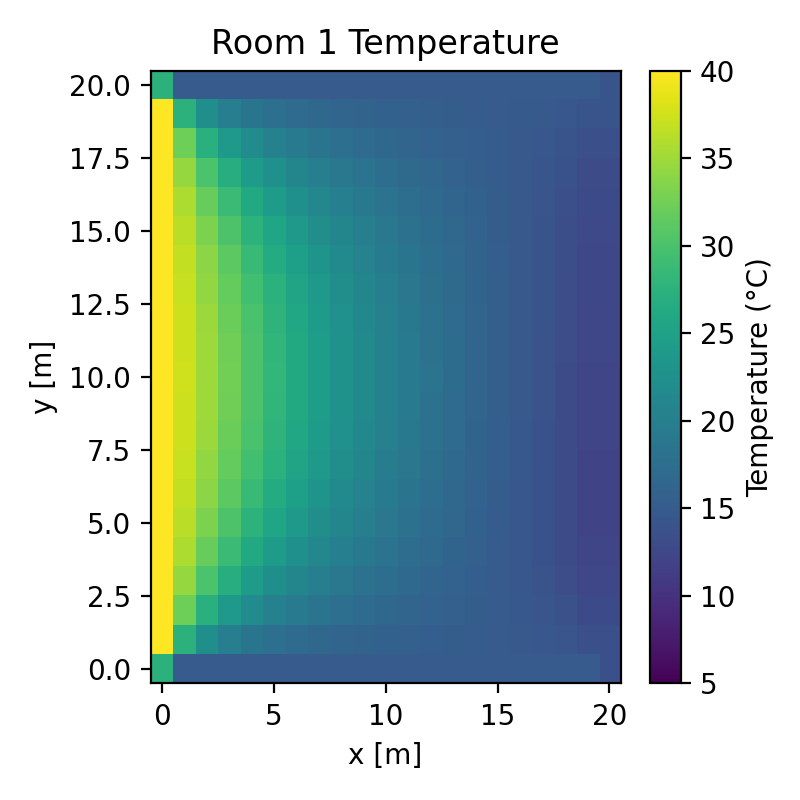

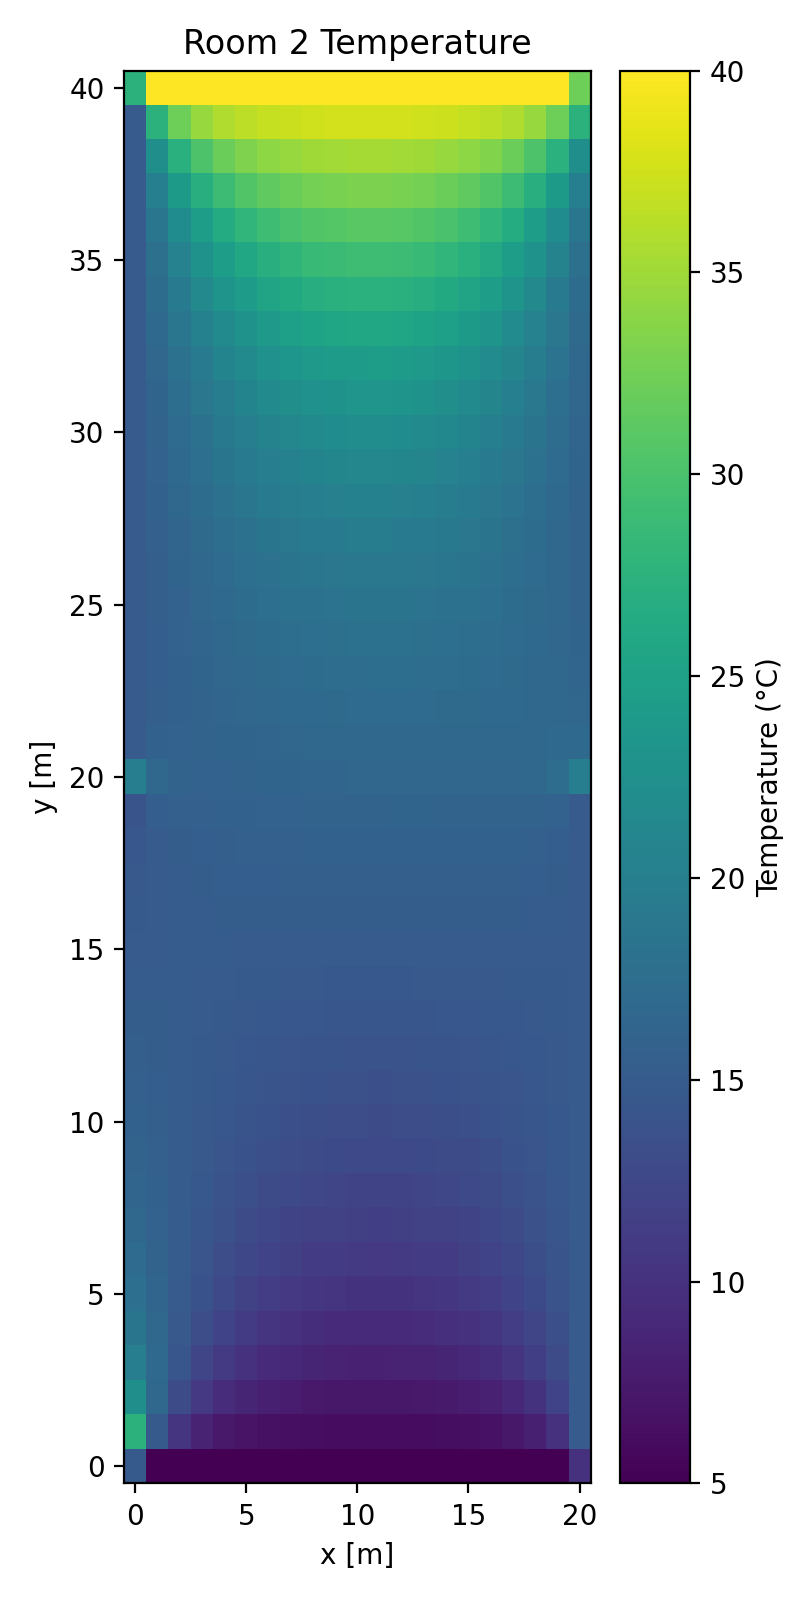

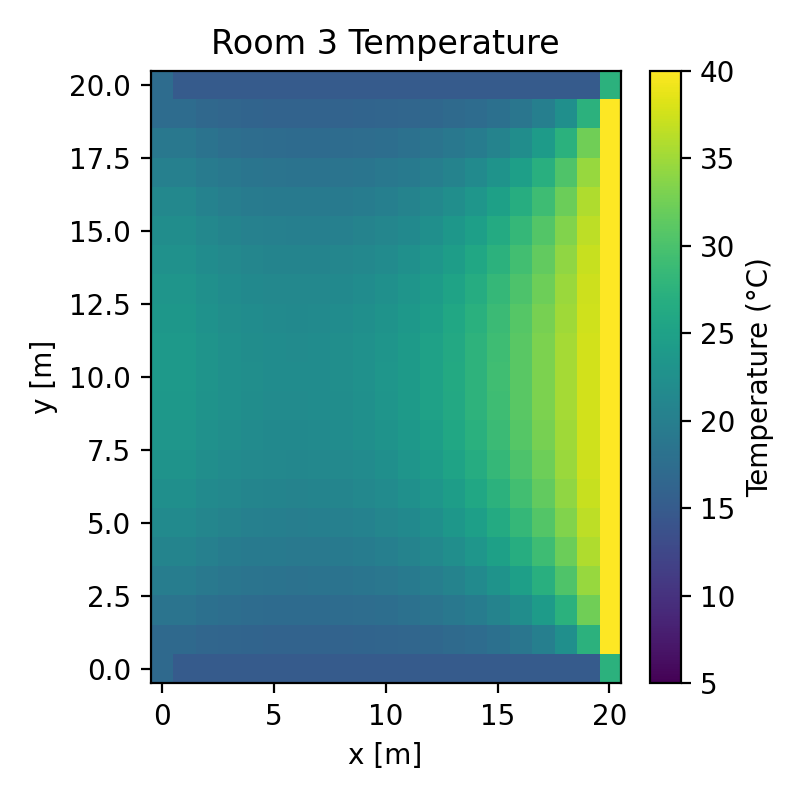

In [9]:
import os
from IPython.display import Image, display

outdir = "output"
files = [f"room{i}.png" for i in (1,2,3)]
for f in files:
    p = os.path.join(outdir, f)
    if os.path.exists(p):
        display(Image(filename=p))
    else:
        print("Missing:", p)


## Task 4 — Parameter sensitivity

Running: C:\Program Files\Microsoft MPI\Bin\mpiexec.exe -n 4 python main.py --heater-temp 40.0 --window-temp 5.0 --wall-temp 15.0 --iters 10
heater=40.0°C, K=10, procs=4, apt=old -> meanT=19.73°C

Running: C:\Program Files\Microsoft MPI\Bin\mpiexec.exe -n 4 python main.py --heater-temp 20.0 --window-temp 5.0 --wall-temp 15.0 --iters 10
heater=20.0°C, K=10, procs=4, apt=old -> meanT=15.47°C

Running: C:\Program Files\Microsoft MPI\Bin\mpiexec.exe -n 4 python main.py --heater-temp 30.0 --window-temp 5.0 --wall-temp 15.0 --iters 10
heater=30.0°C, K=10, procs=4, apt=old -> meanT=17.60°C

Running: C:\Program Files\Microsoft MPI\Bin\mpiexec.exe -n 4 python main.py --heater-temp 50.0 --window-temp 5.0 --wall-temp 15.0 --iters 10
heater=50.0°C, K=10, procs=4, apt=old -> meanT=21.87°C

Running: C:\Program Files\Microsoft MPI\Bin\mpiexec.exe -n 4 python main.py --heater-temp 60.0 --window-temp 5.0 --wall-temp 15.0 --iters 10
heater=60.0°C, K=10, procs=4, apt=old -> meanT=24.00°C

Running: C:\Pro

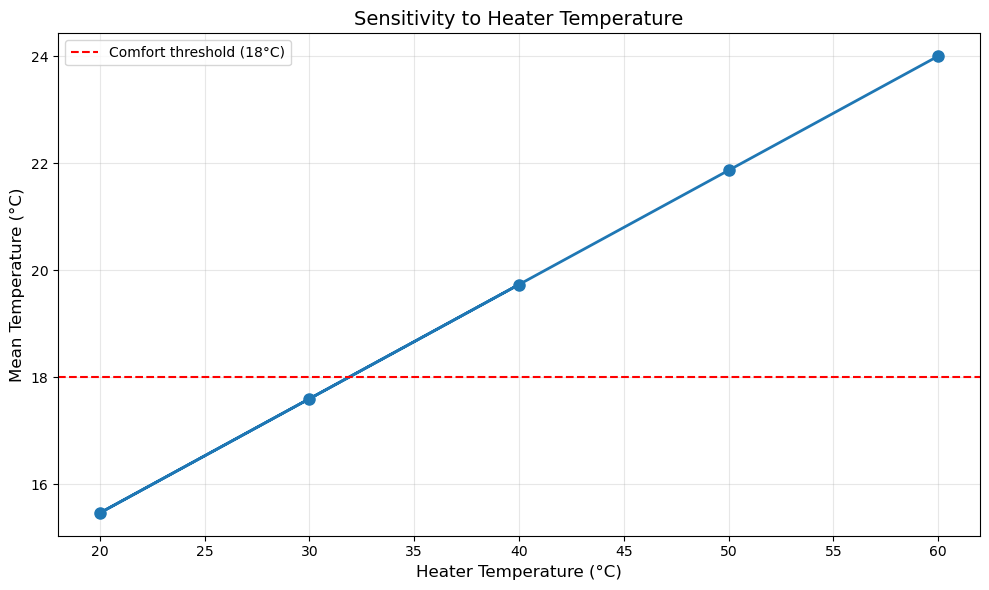

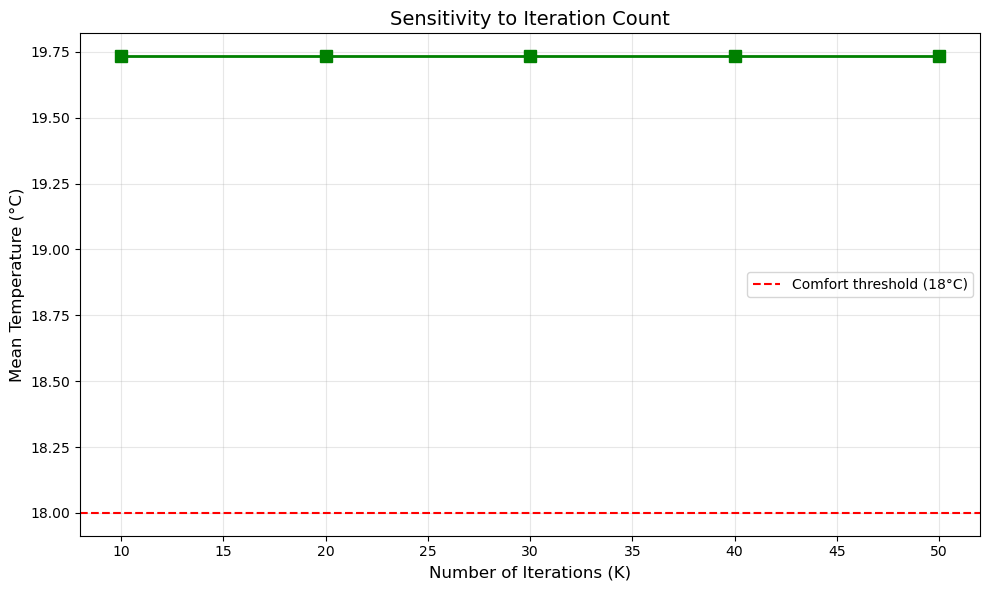


Summary of Parameter Sensitivity Analysis
Heater(°C)   Iters    Procs    Apt Type     Mean T(°C)   Adequate? 
--------------------------------------------------------------------------------
40.0         10       4        Old          19.73        YES       
20.0         10       4        Old          15.47        NO        
30.0         10       4        Old          17.60        NO        
50.0         10       4        Old          21.87        YES       
60.0         10       4        Old          24.00        YES       
40.0         20       4        Old          19.73        YES       
40.0         30       4        Old          19.73        YES       
40.0         40       4        Old          19.73        YES       
40.0         50       4        Old          19.73        YES       


In [10]:
## Task 4 — Parameter sensitivity
import os, subprocess, numpy as np

MAIN = os.path.join("main.py")


def run_case(heater_temp=40.0, window_temp=5.0, wall_temp=15.0, num_iters=10, nproc=4, new_apartment=False):
    """
    Run a single simulation case with specified parameters.

    Args:
        heater_temp: Heater temperature in °C
        window_temp: Window temperature in °C
        wall_temp: Wall temperature in °C
        num_iters: Number of D-N iterations
        nproc: Number of MPI processes (4 for old apt, 5 for new apt)
        new_apartment: Whether to use new apartment layout

    Returns:
        Mean temperature across all rooms
    """
    cmd = [mpiexec, "-n", str(nproc), "python", MAIN,
           "--heater-temp", str(heater_temp),
           "--window-temp", str(window_temp),
           "--wall-temp", str(wall_temp),
           "--iters", str(num_iters)]

    if new_apartment:
        cmd.append("-n")

    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)

    # Read outputs (old apartment → output; new apartment → ext_output)
    out = "ext_output" if new_apartment else "output"
    u_files = ["u1.npy", "u2.npy", "u3.npy"]
    if new_apartment:
        u_files.append("u4.npy")

    U = []
    for f in u_files:
        path = os.path.join(PROJECT_ROOT, out, f)
        if os.path.exists(path):
            U.append(np.load(path))

    # Statistics (use global mean temperature; can switch to interface residual)
    all_vals = np.concatenate([u[~np.isnan(u)].ravel() for u in U])
    return float(all_vals.mean())


# Parameter sweep configurations
configs = [
    # Baseline
    dict(heater_temp=40.0, window_temp=5.0, wall_temp=15.0, num_iters=10, nproc=4, new_apartment=False),
    # Vary heater temperature
    dict(heater_temp=20.0, window_temp=5.0, wall_temp=15.0, num_iters=10, nproc=4, new_apartment=False),
    dict(heater_temp=30.0, window_temp=5.0, wall_temp=15.0, num_iters=10, nproc=4, new_apartment=False),
    dict(heater_temp=50.0, window_temp=5.0, wall_temp=15.0, num_iters=10, nproc=4, new_apartment=False),
    dict(heater_temp=60.0, window_temp=5.0, wall_temp=15.0, num_iters=10, nproc=4, new_apartment=False),
    # Vary iteration count
    dict(heater_temp=40.0, window_temp=5.0, wall_temp=15.0, num_iters=20, nproc=4, new_apartment=False),
    dict(heater_temp=40.0, window_temp=5.0, wall_temp=15.0, num_iters=30, nproc=4, new_apartment=False),
    dict(heater_temp=40.0, window_temp=5.0, wall_temp=15.0, num_iters=40, nproc=4, new_apartment=False),
    dict(heater_temp=40.0, window_temp=5.0, wall_temp=15.0, num_iters=50, nproc=4, new_apartment=False)
]

records = []
for c in configs:
    meanT = run_case(**c)
    records.append((c["heater_temp"], c["num_iters"], c["nproc"], c["new_apartment"], meanT))
    apt_type = "new" if c["new_apartment"] else "old"
    print(f"heater={c['heater_temp']}°C, K={c['num_iters']}, procs={c['nproc']}, apt={apt_type} -> meanT={meanT:.2f}°C\n")

# Plot - heater temperature sensitivity analysis
import matplotlib.pyplot as plt

# Filter records with num_iters=10 and old apartment
heater_sensitivity = [r for r in records if r[1] == 10 and not r[3]]
heater_temps = [r[0] for r in heater_sensitivity]
mean_temps = [r[4] for r in heater_sensitivity]

plt.figure(figsize=(10, 6))
plt.plot(heater_temps, mean_temps, marker='o', linewidth=2, markersize=8)
plt.xlabel('Heater Temperature (°C)', fontsize=12)
plt.ylabel('Mean Temperature (°C)', fontsize=12)
plt.title('Sensitivity to Heater Temperature', fontsize=14)
plt.axhline(y=18.0, color='r', linestyle='--', label='Comfort threshold (18°C)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot - iteration count sensitivity analysis
iter_sensitivity = [r for r in records if r[0] == 40.0 and not r[3]]
iters = [r[1] for r in iter_sensitivity]
mean_temps_iter = [r[4] for r in iter_sensitivity]

plt.figure(figsize=(10, 6))
plt.plot(iters, mean_temps_iter, marker='s', linewidth=2, markersize=8, color='green')
plt.xlabel('Number of Iterations (K)', fontsize=12)
plt.ylabel('Mean Temperature (°C)', fontsize=12)
plt.title('Sensitivity to Iteration Count', fontsize=14)
plt.axhline(y=18.0, color='r', linestyle='--', label='Comfort threshold (18°C)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print complete results table
print("\n" + "=" * 80)
print("Summary of Parameter Sensitivity Analysis")
print("=" * 80)
print(f"{'Heater(°C)':<12} {'Iters':<8} {'Procs':<8} {'Apt Type':<12} {'Mean T(°C)':<12} {'Adequate?':<10}")
print("-" * 80)
for r in records:
    apt_type = "New" if r[3] else "Old"
    adequate = "YES" if r[4] > 18.0 else "NO"
    print(f"{r[0]:<12.1f} {r[1]:<8} {r[2]:<8} {apt_type:<12} {r[4]:<12.2f} {adequate:<10}")
print("=" * 80)

## Project 3a — 2.5 rooms

In [ ]:
cmd = [mpiexec, "-n", "5", "python", f"main.py", "-n"]

result = subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

print(result.stdout)

# or you can use command below:
#!mpiexec -n 5 python main.py -n

[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C



Simulation Configuration:
  - Apartment: New (4 rooms)
  - Grid spacing: dx=0.05, dy=0.05
  - D-N iterations: 10
  - Solver: direct (tol=1e-06)
  - Temperatures: Heater=40.0°C, Window=5.0°C, Wall=15.0°C


Is the heating in the flat adequate?
1. Lowest temp:6.50 °C
2. Averaged temp:21.10°C
3. Highest temp:39.59°C
--------------------------------------------------
Averged tempture > 18°C. The heating in the flat is adequate.

Saved: d:\LU D\course\Advanced Course in Numerical Algorithms with PythonSciPy\Project3\Project_3\core\..\ext_output\room1.png
Saved: d:\LU D\course\Advanced Course in Numerical Algorithms with 

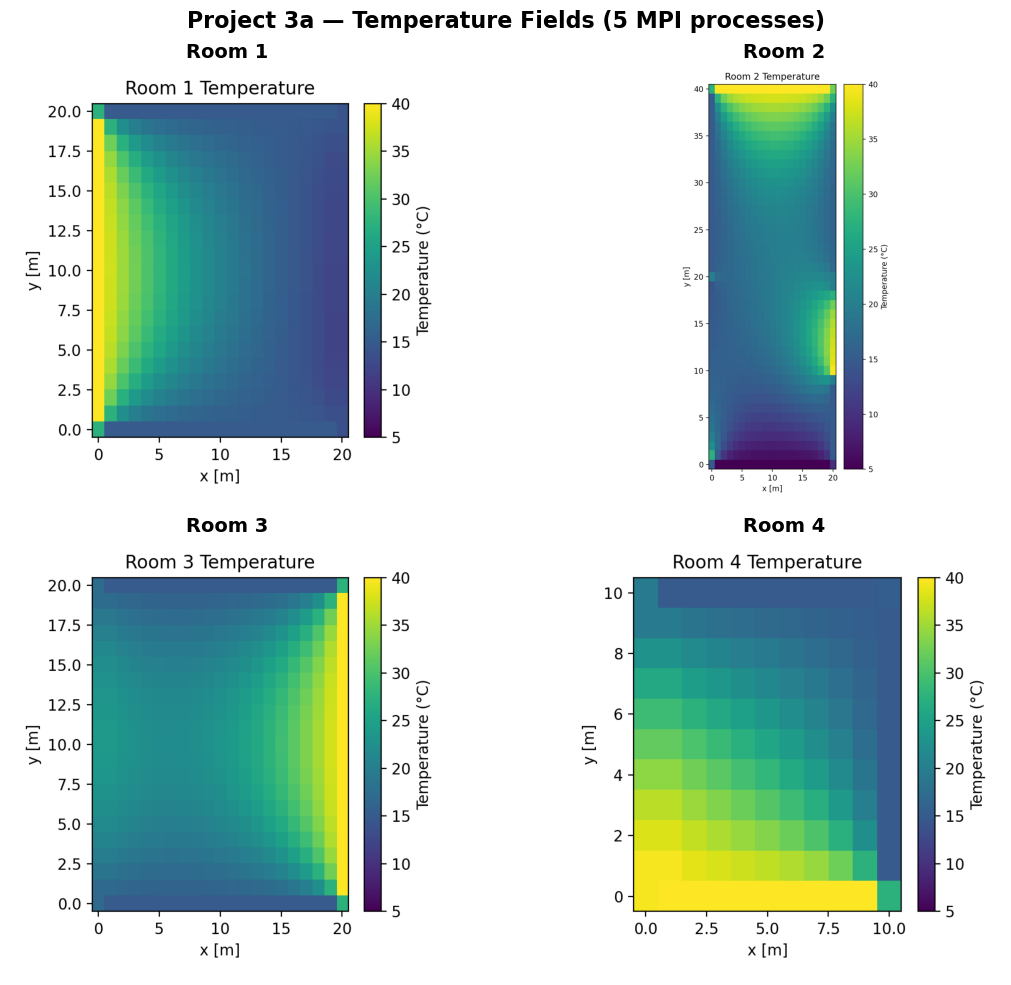

Combined plot saved to: ext_output\combined_4rooms.png


In [13]:
import os
from matplotlib.image import imread
import matplotlib.pyplot as plt



outdir = "output"
ext_dir = "ext_output"

# 4-room collage plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
names = [
    ("room1.png", "Room 1"),
    ("room2.png", "Room 2"),
    ("room3.png", "Room 3"),
    ("room4.png", "Room 4")
]

for ax, (fname, title) in zip(axes.ravel(), names):
    path = os.path.join(ext_dir, fname)
    if os.path.exists(path):
        img = imread(path)
        ax.imshow(img)
        ax.set_title(title, fontsize=14, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f"Missing:\n{fname}",
                ha='center', va='center', fontsize=12, color='red')
    ax.axis('off')

fig.suptitle("Project 3a — Temperature Fields (5 MPI processes)",
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(ext_dir, "combined_4rooms.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"Combined plot saved to: {os.path.join(ext_dir, 'combined_4rooms.png')}")



## Project 3a (Task 2): Δx = 1/100
This section uses a finer grid (Δx = Δy = 0.01) to improve accuracy.
Due to the large increase in grid points, we use:
- **Sparse matrices** to reduce memory consumption
- **spsolve solver**: sparse direct solve, fast and accurate
- **More iterations** to ensure D–N iteration convergence

Running Project 3a Task 2 with fine grid (Δx=1/100)
Command: C:\Program Files\Microsoft MPI\Bin\mpiexec.exe -n 5 python main.py -n --dx 0.01 --dy 0.01 --iters 20 --heater-temp 40.0 --solver spsolve --solver-tol 1e-06

[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C

Simulation Configuration:
  - Apartment: New (4 rooms)
  - Grid spacing: dx=0.01, dy=0.01
  - D-N iterations: 20
  - Solver: spsolve (tol=1e-06)
  - Temperatures: Heater=40.0°C, Window=5.0°C, Wall=15.0°C

[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C
[Config] Updated boundary temps → Heater=40.0°C, Window=5.0°C, Wall=15.0°C

Is the heating in the flat adequate?
1. Lowest temp:5.28 °C
2. Averaged temp:21.06°C
3. Highest temp:40.57°C
--------------------------------------------------
Averged tempture > 18°C. The heating in 

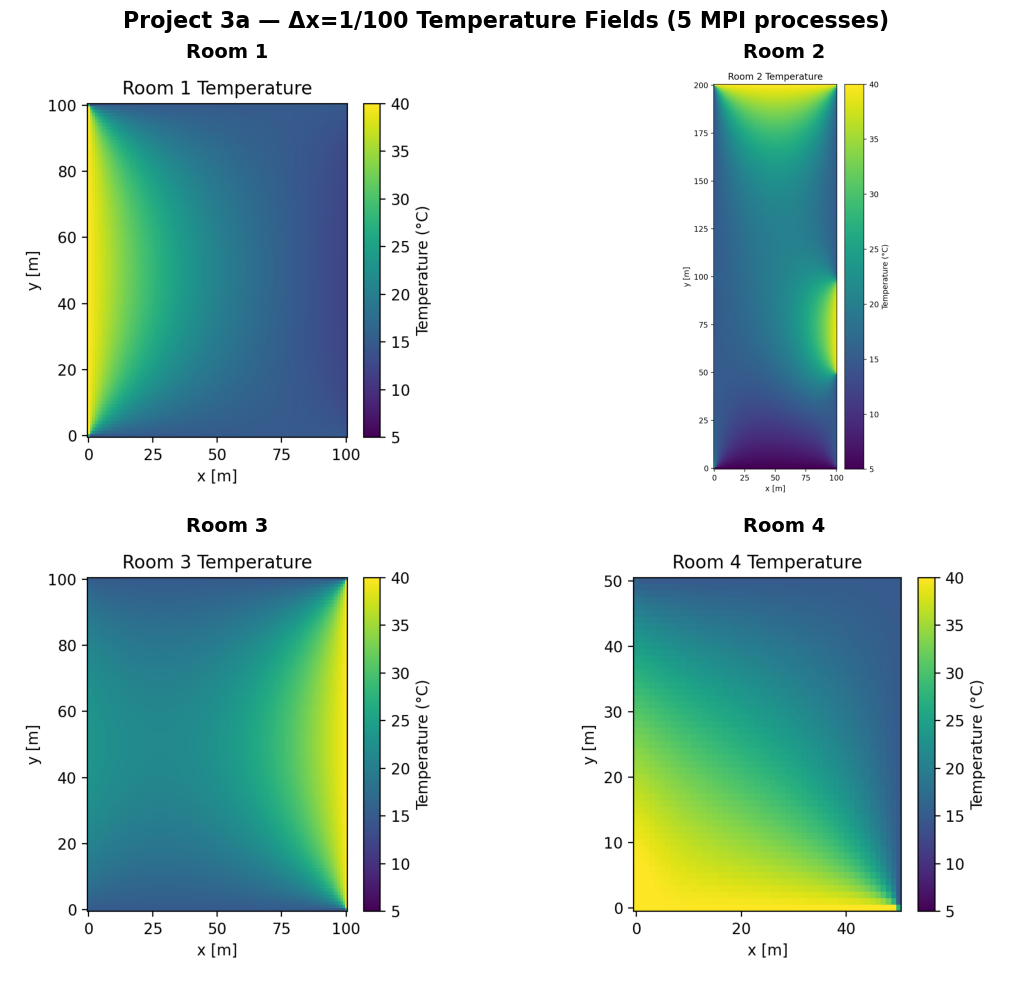

Combined plot saved to: ext_output\combined_4rooms.png


In [15]:
import os, time, subprocess, numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Run configuration
DX = DY = 0.01       # Δx = Δy = 1/100
K  = 20              # Number of D–N iterations
OMEGA = 0.8          # Relaxation parameter
NPROC = 5            # 2.5 rooms → 5 MPI processes
HEATER = 40.0        # Heater temperature (consistent with earlier)
SOLVER = "spsolve"   # Use sparse direct solver (or set to "cg"/"gmres")
SOLVER_TOL = 1e-6    # Tolerance for iterative solvers

# Entrypoint and mpiexec
MAIN = os.path.join("main.py")
cmd = [
    mpiexec, "-n", str(NPROC), "python", MAIN,
    "-n",
    "--dx", str(DX), "--dy", str(DY),
    "--iters", str(K),
    "--heater-temp", str(HEATER),
    "--solver", SOLVER,           # choose solver type
    "--solver-tol", str(SOLVER_TOL)
]

print("="*70)
print("Running Project 3a Task 2 with fine grid (Δx=1/100)")
print("="*70)
print("Command:", " ".join(cmd))
print()

t0 = time.perf_counter()
result = subprocess.run(cmd, check=True, capture_output=True, text=True)
t1 = time.perf_counter()

# Print captured output (solver info, etc.)
print(result.stdout)
if result.stderr:
    print("Warnings/Errors:", result.stderr)

print(f"\n{'='*70}")
print(f"Total wall-clock time: {t1 - t0:.2f} seconds")
print(f"{'='*70}\n")

ext_dir = os.path.join(PROJECT_ROOT, "ext_output")
fields, u_files = [], ["u1.npy", "u2.npy", "u3.npy", "u4.npy"]

for f in u_files:
    p = os.path.join(ext_dir, f)
    if os.path.exists(p):
        fields.append(np.load(p))
    else:
        print(f"Warning: Missing file {p}")

all_vals = np.concatenate([u[~np.isnan(u)].ravel() for u in fields])
u_min = float(all_vals.min())
u_mean = float(all_vals.mean())
u_max = float(all_vals.max())

print("\n" + "="*70)
print("Temperature Statistics (Δx=1/100, 5 MPI processes)")
print("="*70)
print(f"  Min temperature:  {u_min:.4f} °C")
print(f"  Mean temperature: {u_mean:.4f} °C")
print(f"  Max temperature:  {u_max:.4f} °C")
print("-"*70)
print(f"  Heating adequate: {'YES' if u_mean > 18.0 else 'NO'} (threshold: 18°C)")
print("="*70 + "\n")

# 4-room collage plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
names = [
    ("room1.png", "Room 1"),
    ("room2.png", "Room 2"),
    ("room3.png", "Room 3"),
    ("room4.png", "Room 4")
]

for ax, (fname, title) in zip(axes.ravel(), names):
    path = os.path.join(ext_dir, fname)
    if os.path.exists(path):
        img = imread(path)
        ax.imshow(img)
        ax.set_title(title, fontsize=14, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f"Missing:\n{fname}",
                ha='center', va='center', fontsize=12, color='red')
    ax.axis('off')

fig.suptitle("Project 3a — Δx=1/100 Temperature Fields (5 MPI processes)",
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(ext_dir, "combined_4rooms.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"Combined plot saved to: {os.path.join(ext_dir, 'combined_4rooms.png')}")

